## Transformers for Timeseries

Click to run on colab (if you're not already there): [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/charlesollion/dlexperiments/blob/master/7-Transformers-Timeseries/Transformers_for_timeseries.ipynb)

The goal of this notebook is to illustrate the use of a transformer for timeseries prediction.

In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

### Preparing the Dataset
Energy consumption dataset from https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
* gathers 10-min measurements of household appliances energy consumption (20 first features), coupled with local meteorological data (8 last features).
* The time-series forecasting task is to predict the first 20 features, given as input data the 28 features. A window of observations of 12 time steps is considered to predict the next series of observations (this corresponds to a 2-hours window of observations.

you may get the dataset (a single csv file) by running the following cell:

In [2]:
!wget https://raw.githubusercontent.com/LuisM78/Appliances-energy-prediction-data/master/energydata_complete.csv

--2025-05-21 16:15:35--  https://raw.githubusercontent.com/LuisM78/Appliances-energy-prediction-data/master/energydata_complete.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11979363 (11M) [text/plain]
Saving to: ‘energydata_complete.csv’

energydata_complete 100%[===================>]  11.42M  --.-KB/s    in 0.1s    

2025-05-21 16:15:36 (92.2 MB/s) - ‘energydata_complete.csv’ saved [11979363/11979363]



In [3]:
# load and preprocess the energy dataset:
def convert_col_into_float(df, list_cols):
    for col in list_cols:
        df[col] = df[col].astype(str)
        df[col] = df[col].str.replace(',', '.')
        df[col] = df[col].astype(np.float32)
    return df
df = pd.read_csv("energydata_complete.csv", index_col='date', parse_dates=['date'])
print(df.head())
list_cols = list(df.columns)
# gathers 10-min measurements of household appliances energy consumption (20 first features), coupled with local meteorological data. (8 last features)
print("dataset variables", list_cols)
df = convert_col_into_float(df, list_cols)
data = df.values

                     Appliances  lights     T1       RH_1    T2       RH_2  \
date                                                                         
2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

                        T3       RH_3         T4       RH_4  ...         T9  \
date                                                         ...              
2016-01-11 17:00:00  19.79  44.730000  19.000000  45.566667  ...  17.033333   
2016-01-11 17:10:00  19.79  44.790000  19.000000  45.992500  ...  17.066667   
2016-01-11 17:20:00  19.79  44.933333  18.926667  45.890000  ...  17.000000   
2016-01-11 17:30:00  19.79  45.000000  18.890000  45.72333

In [4]:
def split_dataset_into_seq(dataset, start_index=0, end_index=None, history_size=13, step=1):
    '''split the dataset to have sequence of observations of length history size'''
    data = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
    return np.array(data)

In [5]:
def split_dataset(data, TRAIN_SPLIT=0.7, VAL_SPLIT=0.5, save_path=None):
    '''split the dataset into train, val and test splits'''
    # normalization
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data = (data - data_mean) / data_std
    stats = (data_mean, data_std)

    data_in_seq = split_dataset_into_seq(data, start_index=0, end_index=None, history_size=13, step=1)

    # split between validation dataset and test set:
    train_data, val_data = train_test_split(data_in_seq, train_size=TRAIN_SPLIT, shuffle=True, random_state=123)
    val_data, test_data = train_test_split(val_data, train_size=VAL_SPLIT, shuffle=True, random_state=123)

    return train_data, val_data, test_data

In [6]:
def split_fn(chunk):
    """to split the dataset sequences into input and targets sequences"""
    inputs = torch.tensor(chunk[:, :-1, :], device=device)
    targets = torch.tensor(chunk[:, 1:, :], device=device)
    return inputs, targets

In [7]:
def data_to_dataset(train_data, val_data, test_data, batch_size=32, target_features=list(range(20))):
    '''
    split each train split into inputs and targets
    convert each train split into a tf.dataset
    '''
    x_train, y_train = split_fn(train_data)
    x_val, y_val = split_fn(val_data)
    x_test, y_test = split_fn(test_data)
    # selecting only the first 20 features for prediction:
    y_train = y_train[:, :, target_features]
    y_val = y_val[:, :, target_features]
    y_test = y_test[:, :, target_features]
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
    test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, val_loader, test_loader

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
train_data, val_data, test_data = split_dataset(data)
train_dataset, val_dataset, test_dataset = data_to_dataset(train_data, val_data, test_data)

### Implementation of the Transformer model

In [10]:
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    '''Multi-head self-attention module'''
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension

        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)

        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

In [11]:
B, S, H, D = 9, 11, 5, 8
mha = MultiHeadAttention(D, H)
out, att = mha.forward(torch.zeros(B, S, D), mask=None)
out.shape, att.shape

(torch.Size([9, 11, 8]), torch.Size([9, 5, 11, 11]))

In [12]:
# Positional encodings
def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=20, dim=3, device=device):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
    return torch.tensor(pos_encoding, device=device)

In [13]:
# function that implement the look_ahead mask for masking future time steps.
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask  # (size, size)

In [14]:
create_look_ahead_mask(6)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [15]:
class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)


    def forward(self, x, look_ahead_mask):

        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)

        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights

In [16]:
dl = TransformerLayer(16, 3, 32, 0.1)
out, attn = dl(x=torch.zeros(5, 7, 16), look_ahead_mask=None)
out.shape, attn.shape

(torch.Size([5, 7, 16]), torch.Size([5, 3, 7, 7]))

In [17]:
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim,
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        B, S, D = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D

        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block

        x = self.output_projection(x)

        return x, attention_weights # (B,S,S)

In [18]:
# Test Forward pass on the Transformer:
transformer = Transformer(num_layers=1, D=32, H=1, hidden_mlp_dim=32,
                                       inp_features=28, out_features=20, dropout_rate=0.1)
transformer.to(device)
(inputs, targets) = next(iter(train_dataset))

S = inputs.shape[1]
mask = create_look_ahead_mask(S)
out, attn = transformer (x=inputs, mask=mask)
out.shape, attn["decoder_layer1"].shape

(torch.Size([32, 12, 20]), torch.Size([32, 1, 12, 12]))

## Training the Transformer

In [19]:
param_sizes = [p.numel() for p in transformer.parameters()]
print(f"number of weight/biases matrices: {len(param_sizes)} "
      f"for a total of {np.sum(param_sizes)} parameters ")

number of weight/biases matrices: 20 for a total of 8052 parameters 


In [20]:
transformer = Transformer(num_layers=1, D=32, H=4, hidden_mlp_dim=32,
                          inp_features=28, out_features=20, dropout_rate=0.1).to(device)
optimizer = torch.optim.RMSprop(transformer.parameters(),
                                lr=0.00005)

In [21]:
from tqdm import tqdm

n_epochs = 20
niter = len(train_dataset)
losses, val_losses = [], []

for e in tqdm(range(n_epochs)):

    # one epoch on train set
    transformer.train()
    sum_train_loss = 0.0
    for x,y in train_dataset:
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(sum_train_loss / niter)

    # Evaluate on val set
    transformer.eval()
    sum_val_loss = 0.0
    for i, (x, y) in enumerate(val_dataset):
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_val_loss += loss.item()
    val_losses.append(sum_val_loss / (i + 1))

100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


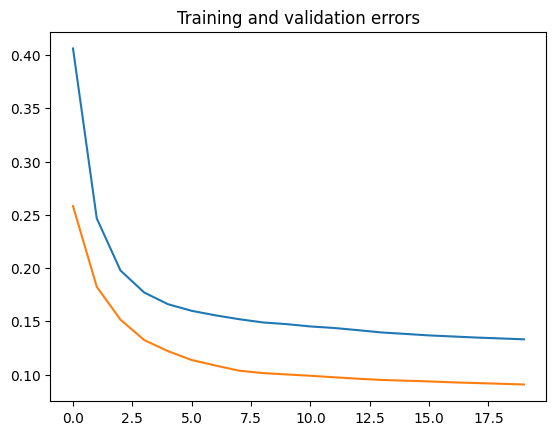

In [24]:
plt.title("Training and validation errors")
plt.savefig("TrainValErrors.png", dpi=250)
plt.plot(losses)
plt.plot(val_losses);

### Evaluation on Test set

In [23]:
test_losses, test_preds  = [], []
transformer.eval()
for (x, y) in test_dataset:
    S = x.shape[-2]
    y_pred, _ = transformer(x,
                            mask=create_look_ahead_mask(S))
    loss_test = torch.nn.MSELoss()(y_pred, y)  # (B,S)
    test_losses.append(loss_test.item())
    test_preds.append(y_pred.detach().cpu().numpy())
test_preds = np.vstack(test_preds)
np.mean(test_losses)

np.float64(0.09003177253148889)

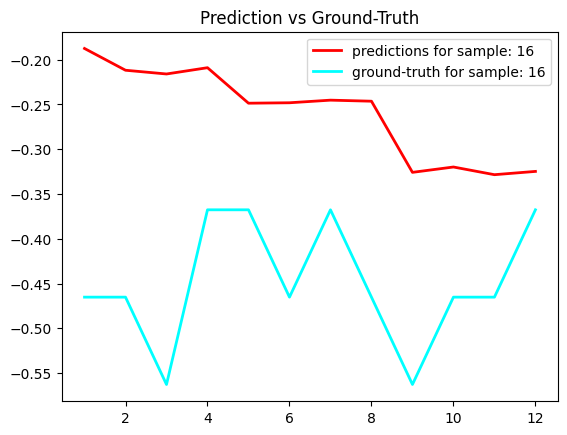

In [25]:
# Display predictions vs ground truth:
# we'll take one random element of the first batch
# and display the first feature
seq_len = 12
index = np.random.randint(32)
feature_num = 0

x_test, _ = test_dataset.dataset.tensors
x_test = x_test[index, :, feature_num].cpu().numpy()
pred = test_preds[index, :, feature_num]
x = np.linspace(1, seq_len, seq_len)
plt.title("Prediction vs Ground-Truth")
plt.savefig("PredictionVsGroundTruth.png", dpi=250)
plt.plot(x, pred, 'red', lw=2, label='predictions for sample: {}'.format(index))
plt.plot(x, x_test, 'cyan', lw=2, label='ground-truth for sample: {}'.format(index))
plt.legend(fontsize=10)
plt.show()